In [1]:
%matplotlib inline

from mesa import Mesa
from utils import Rater, load_dataset
from jupyter_argparser.core import argparse
from sklearn.tree import *
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser(description='Mesa Arguments')
parser.add_argument('--env-name', default="MESA-SAC")

# SAC arguments
parser.add_argument('--policy', default="Gaussian",
                    help='Policy Type: Gaussian | Deterministic (default: Gaussian)')
parser.add_argument('--eval', type=bool, default=True,
                    help='Evaluates a policy every 10 episode (default: True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.01, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.01)')
parser.add_argument('--lr', type=float, default=0.001, metavar='G',
                    help='learning rate (default: 0.001)')
parser.add_argument('--lr_decay_steps', type=int, default=10, metavar='N',
                    help='step_size of StepLR learning rate decay scheduler (default: 10)')
parser.add_argument('--lr_decay_gamma', type=float, default=0.99, metavar='N',
                    help='gamma of StepLR learning rate decay scheduler (default: 0.99)')
parser.add_argument('--alpha', type=float, default=0.1, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy\
                            term against the reward (default: 0.1)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Automaically adjust α (default: False)')
parser.add_argument('--seed', type=int, default=None, metavar='N',
                    help='random seed (default: None)')
parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='batch size (default: 64)')
parser.add_argument('--hidden_size', type=int, default=50, metavar='N',
                    help='hidden size (default: 50)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simul|ator step (default: 1)')
parser.add_argument('--update_steps', type=int, default=1000, metavar='N',
                    help='maximum number of steps (default: 1000)')
parser.add_argument('--start_steps', type=int, default=500, metavar='N',
                    help='Steps sampling random actions (default: 500)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--replay_size', type=int, default=1000, metavar='N',
                    help='size of replay buffer (default: 1000)')
parser.add_argument('--cuda', action="store_true", default=False,
                    help='run on CUDA (default: False)')

# MESA arguments
parser.add_argument('--dataset', type=str, default='Mammo', metavar='N',
                    help='the dataset used for meta-training (default: Mammo)')
parser.add_argument('--metric', type=str, default='aucprc', metavar='N',
                    help='the metric used for evaluate (default: aucprc)')
parser.add_argument('--reward_coefficient', type=float, default=100, metavar='N')
parser.add_argument('--num_bins', type=int, default=5, metavar='N', 
                    help='number of bins (default: 5). state-size = 2 * num_bins.')
parser.add_argument('--sigma', type=float, default=0.2, metavar='N', 
                    help='sigma of the Gaussian function used in meta-sampling (default: 0.2)')
parser.add_argument('--max_estimators', type=int, default=10, metavar='N',
                    help='maximum number of base estimators in each meta-training episode (default: 10)')
parser.add_argument('--meta_verbose', type=int, default=10, metavar='N',
                    help='number of episodes between verbose outputs. \
                    If \'full\' print log for each base estimator (default: 10)')
parser.add_argument('--meta_verbose_mean_episodes', type=int, default=25, metavar='N',
                    help='number of episodes used for compute latest mean score in verbose outputs.')
parser.add_argument('--verbose', type=bool, default=False, metavar='N',
                    help='enable verbose when ensemble fit (default: False)')
parser.add_argument('--random_state', type=int, default=None, metavar='N', 
                    help='random_state (default: None)')
parser.add_argument('--train_ir', type=float, default=1, metavar='N', 
                    help='imbalance ratio of the training set after meta-sampling (default: 1)')
parser.add_argument('--train_ratio', type=float, default=1, metavar='N', 
                    help='the ratio of the data used in meta-training. \
                    set train_ratio<1 to use a random subset for meta-training (default: 1)')

# Initialization and meta-training

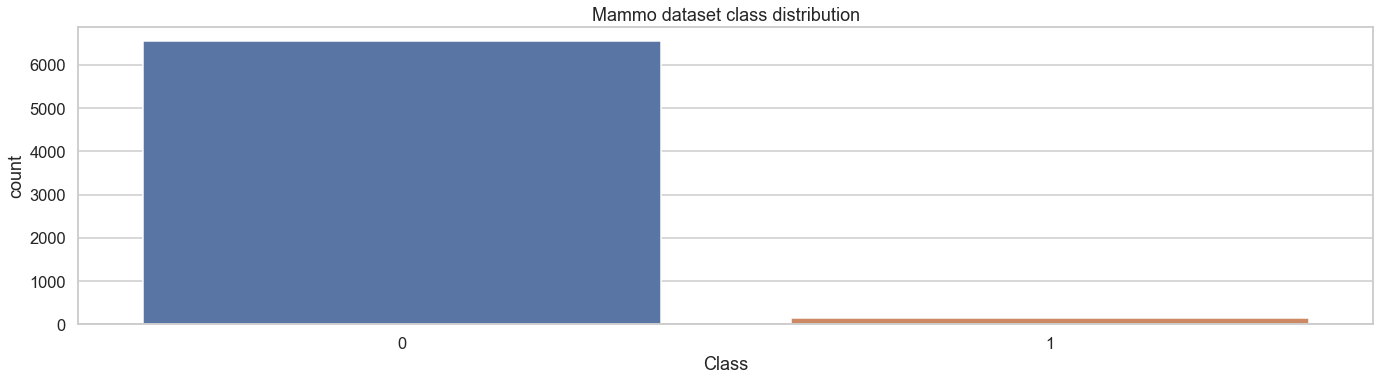

In [2]:
''' Prepare the Environment '''

#  load dataset
dataset = 'Mammo'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset(dataset)
estimator, base_estimator = 'DT', DecisionTreeClassifier(max_depth=None)
args = parser.parse_args()
n_estimators = args.max_estimators

# plot the class distribution
def plot_class_distribution(y, ax, title):
    sns.countplot(data=pd.DataFrame(y, columns=['Class']), x='Class', ax=ax)
    ax.set(title=title)
   
sns.set(style='whitegrid')
sns.set_context('talk', font_scale=1)
fig, ax = plt.subplots(figsize=(20, 6))
plot_class_distribution(y_train, ax, title=f'{dataset} dataset class distribution')
plt.tight_layout(pad=1.8)
plt.show()

In [3]:
''' Meta-training '''

# initialize MESA
print ('Dataset: {}'.format(dataset))
mesa = Mesa(
    args=args, 
    base_estimator=base_estimator, 
    n_estimators=args.max_estimators)

# start meta-training
print ('Start meta-training of MESA ... ...')
start_time = time.clock()
mesa.meta_fit(X_train, y_train, X_valid, y_valid, X_test, y_test)
end_time = time.clock()
print ('Meta-training time: {:.3f} s'.format(end_time - start_time))

Dataset: Mammo
Start meta-training of MESA ... ...
Epi.10   updates 0    |last-25-mean-aucprc| train 0.903 | valid 0.498 | test 0.549 | by rand
Epi.20   updates 0    |last-25-mean-aucprc| train 0.895 | valid 0.494 | test 0.549 | by rand
Epi.30   updates 0    |last-25-mean-aucprc| train 0.890 | valid 0.488 | test 0.530 | by rand
Epi.40   updates 0    |last-25-mean-aucprc| train 0.907 | valid 0.511 | test 0.542 | by rand
Epi.50   updates 0    |last-25-mean-aucprc| train 0.887 | valid 0.508 | test 0.530 | by rand
Epi.60   updates 40   |last-25-mean-aucprc| train 0.869 | valid 0.499 | test 0.527 | by mesa
Epi.70   updates 130  |last-25-mean-aucprc| train 0.898 | valid 0.528 | test 0.574 | by mesa
Epi.80   updates 220  |last-25-mean-aucprc| train 0.971 | valid 0.588 | test 0.644 | by mesa
Epi.90   updates 310  |last-25-mean-aucprc| train 0.975 | valid 0.601 | test 0.656 | by mesa
Epi.100  updates 400  |last-25-mean-aucprc| train 0.976 | valid 0.593 | test 0.649 | by mesa
Epi.110  updates 49

# Visualize the meta-training process

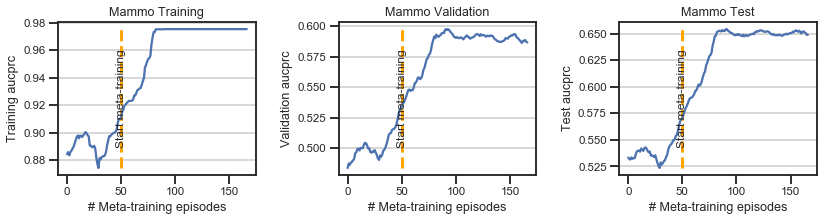

In [4]:
def slide_mean(data, window_half):
    result = []
    for i in range(len(data)):
        lower_bound = max(i-window_half, 0)
        upper_bound = min(i+window_half+1, len(data)-1)
        result.append(np.mean(data[lower_bound:upper_bound]))
    return result

slide_window_half = 25
df_scores = pd.DataFrame(mesa.scores, columns=['Training', 'Validation', 'Test'])

sns.set(style='ticks')
sns.set_context('talk', font_scale=0.7)
fig = plt.figure(figsize=(12, 3.5))
for i in range(df_scores.shape[1]):
    ax = plt.subplot(1, 3, i+1)
    column = df_scores.columns[i]
    view = pd.Series(slide_mean(df_scores[column], slide_window_half))
    sns.lineplot(data=view, ax=ax)
    start_steps = args.start_steps / args.max_estimators
    ax.vlines(start_steps, view.min(), view.max(), color="orange", linestyles='dashed', linewidth=3)
    ax.text(start_steps, 
            (view.min() + view.max()) / 2, 
            'Start meta-training', 
            rotation=90, ha='center', va='center', fontsize=12)
    ax.set(title=f'{dataset} {column}', 
           xlabel='# Meta-training episodes', 
           ylabel=f'{column} {args.metric}')    
    ax.grid(axis='y')

# fig.suptitle(f'Meta-training on {dataset} dataset')
plt.tight_layout(pad=1.8)
plt.show()

# Comparison with baseline methods

In [5]:
'''Ensemble imbalanced learning baselines.'''

from baselines.canonical_ensemble import (BalanceCascade, UnderBagging, RUSBoost, SelfPacedEnsemble)

def run_ensemble(clf, name, runs, rater, actions_list):
    scores_list, time_list = [], []
    for i_run in range(runs):
        clf.estimators_ = []
        start_time = time.clock()
        if name == 'MESA (Ours)':
            clf.fit(X_train, y_train, X_valid, y_valid, verbose=False)
            action_list.append(clf.actions_record)
        else:
            clf.fit(X_train, y_train)
        end_time = time.clock()
        time_list.append(end_time - start_time)
        score_train = rater.score(y_train, clf.predict_proba(X_train)[:,1])
        score_valid = rater.score(y_valid, clf.predict_proba(X_valid)[:,1])
        score_test = rater.score(y_test, clf.predict_proba(X_test)[:,1])
        scores_list.append([score_train, score_valid, score_test])
    return scores_list, time_list

# initialize ensemble imbalanced learning baselines
n_estimators = 10
mesa.n_estimators = n_estimators
spe = SelfPacedEnsemble(base_estimator = base_estimator, n_estimators = n_estimators)
cascade = BalanceCascade(base_estimator = base_estimator, n_estimators = n_estimators)
underbagging = UnderBagging(base_estimator = base_estimator, n_estimators = n_estimators)
rusboost = RUSBoost(base_estimator = base_estimator, n_estimators = n_estimators)

clf_names = ['MESA (Ours)', 'SPE', 'Cascade', 'UnderBagging', 'RUSBoost']
clf_list = [mesa, spe, cascade, underbagging, rusboost]

# run multiple times and show mean-std
runs = 50
action_list, df_scores_list = [], []
metric = 'aucprc'
rater = Rater(metric)
print (f'Dataset: {dataset}\nRunning ensemble imbalanced learning methods:{clf_names}')
for (clf, name) in zip(clf_list, clf_names):
    scores_list, time_list = run_ensemble(clf, name, runs, rater, action_list)
    df_scores = pd.DataFrame(scores_list, columns=['train', 'valid', 'test'])
    info = '{:<12s} |'.format(name)
    for column in df_scores.columns:
        info += ' {} {:.3f}-{:.3f} |'.format(column, df_scores.mean()[column], df_scores.std()[column])
    info += ' {} runs (mean-std) |'.format(runs)
    info += ' ave run time: {:.2f}s'.format(np.mean(time_list))
    print (info)
    df_scores['Method'] = name
    df_scores_list.append(df_scores)

Dataset: Mammo
Running ensemble imbalanced learning methods:['MESA (Ours)', 'SPE', 'Cascade', 'UnderBagging', 'RUSBoost']
MESA (Ours)  | train 0.976-0.000 | valid 0.587-0.036 | test 0.649-0.030 | 50 runs (mean-std) | ave run time: 0.08s
SPE          | train 0.975-0.003 | valid 0.517-0.040 | test 0.566-0.038 | 50 runs (mean-std) | ave run time: 0.05s
Cascade      | train 0.967-0.006 | valid 0.538-0.042 | test 0.573-0.032 | 50 runs (mean-std) | ave run time: 0.44s
UnderBagging | train 0.696-0.038 | valid 0.397-0.031 | test 0.400-0.033 | 50 runs (mean-std) | ave run time: 0.02s
RUSBoost     | train 0.780-0.036 | valid 0.455-0.035 | test 0.484-0.041 | 50 runs (mean-std) | ave run time: 0.03s


In [6]:
'''Resample imbalanced learning baselines.'''

from baselines.canonical_resampling import Resample_classifier

resample_names = ['ORG', 'RUS', 'NM', 'NCR', 'ENN', 
    'Tomek', 'ALLKNN', 'OSS',  'SMOTE', 'ADASYN', 
    'BorderSMOTE', 'SMOTEENN', 'SMOTETomek']

def run_resample(clf, name, runs, rater):
    scores_list, time_list = [], []
    for i_run in range(runs):
        start_time = time.clock()
        X_resampled, y_resampled = clf.resample(X_train, y_train, by=name)
        clf.fit(X_resampled, y_resampled)
        end_time = time.clock()
        time_list.append(end_time - start_time)
        score_train = rater.score(y_train, clf.predict_proba(X_train)[:,1])
        score_valid = rater.score(y_valid, clf.predict_proba(X_valid)[:,1])
        score_test = rater.score(y_test, clf.predict_proba(X_test)[:,1])
        scores_list.append([score_train, score_valid, score_test])
    return scores_list, time_list

# initialize resample imbalanced learning baselines
resample_clf = Resample_classifier(base_estimator=base_estimator)

# run multiple times and show mean-std
print (f'Dataset: {dataset}\nRunning resample imbalanced learning methods: \n{resample_names}')
for resample_name in resample_names:
    scores_list, time_list = run_resample(resample_clf, resample_name, runs, rater)
    df_scores = pd.DataFrame(scores_list, columns=['train', 'valid', 'test'])
    info = '{:<12s} |'.format(resample_name)
    for column in df_scores.columns:
        info += ' {} {:.3f}-{:.3f} |'.format(column, df_scores.mean()[column], df_scores.std()[column])
    info += ' {} runs (mean-std) |'.format(runs)
    info += ' ave run time: {:.2f}s'.format(np.mean(time_list))
    print (info)
    df_scores['Method'] = resample_name
    df_scores_list.append(df_scores)

Dataset: Mammo
Running resample imbalanced learning methods: 
['ORG', 'RUS', 'NM', 'NCR', 'ENN', 'Tomek', 'ALLKNN', 'OSS', 'SMOTE', 'ADASYN', 'BorderSMOTE', 'SMOTEENN', 'SMOTETomek']
ORG          | train 0.976-0.000 | valid 0.338-0.016 | test 0.362-0.017 | 50 runs (mean-std) | ave run time: 0.02s
RUS          | train 0.166-0.021 | valid 0.121-0.014 | test 0.114-0.013 | 50 runs (mean-std) | ave run time: 0.00s
NM           | train 0.032-0.000 | valid 0.032-0.000 | test 0.031-0.000 | 50 runs (mean-std) | ave run time: 0.01s
NCR          | train 0.804-0.008 | valid 0.357-0.022 | test 0.278-0.031 | 50 runs (mean-std) | ave run time: 0.12s
ENN          | train 0.783-0.008 | valid 0.324-0.016 | test 0.298-0.017 | 50 runs (mean-std) | ave run time: 0.11s
Tomek        | train 0.936-0.007 | valid 0.340-0.016 | test 0.331-0.025 | 50 runs (mean-std) | ave run time: 0.10s
ALLKNN       | train 0.751-0.010 | valid 0.335-0.011 | test 0.303-0.017 | 50 runs (mean-std) | ave run time: 0.28s
OSS         

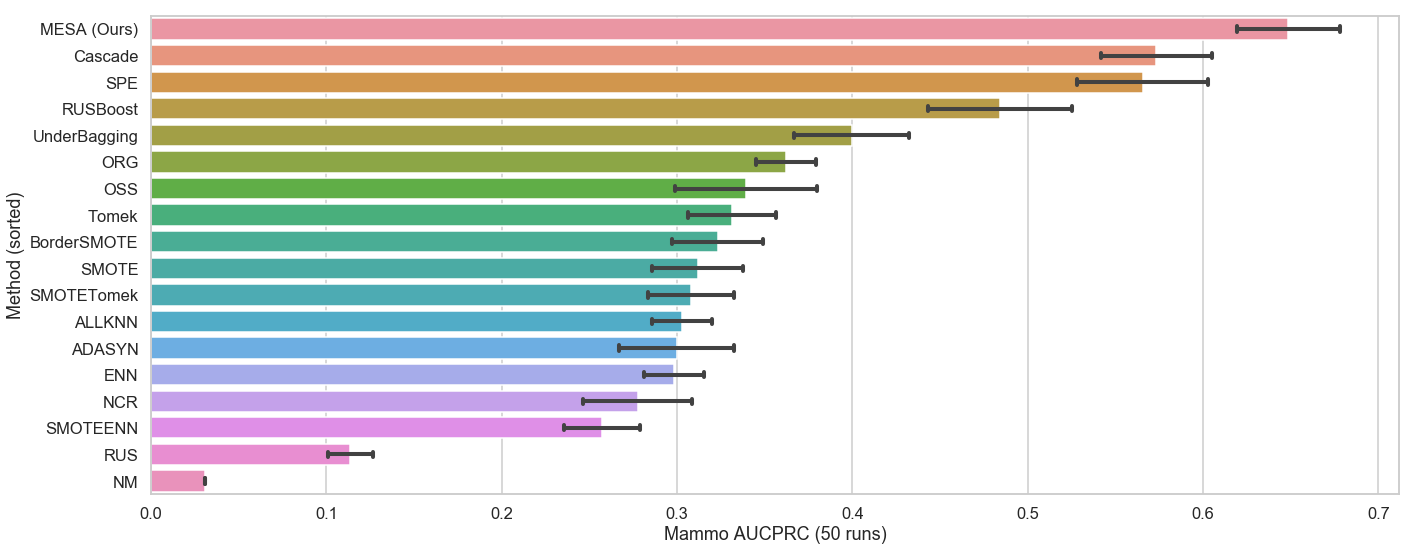

In [7]:
# visualize the performance with error bar
df_scores_all = pd.concat(df_scores_list)
order = df_scores_all.groupby('Method').mean()['test'].sort_values(ascending=False).index.tolist()

fig = plt.figure(figsize=(20, 8))
sns.set(style='whitegrid')
sns.set_context('talk', font_scale=1)
ax = sns.barplot(x='test', y='Method', data=df_scores_all, ci="sd", capsize=.2, order=order)
ax.set(xlabel=f'{dataset} AUCPRC ({runs} runs)', ylabel='Method (sorted)')

plt.xlim(0,)
plt.tight_layout()
plt.show()